# Node Embeddings Clustering and Profiling

In [1]:
import os
import pandas as pd

os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

from config import PATH

seed = 42

In [2]:
df = pd.read_csv(PATH + 'node_embeddings.csv')

In [3]:
n_rows = df.shape[0]

embedding_cols = df.columns.to_list()
embedding_cols.remove('user_id')

# Remove zeros
df = df.loc[~(df[embedding_cols] == 0.0).all(axis=1)]
print('Removed zero embeddings:')
print(f"Nodes remaining = {df.shape[0]}/{n_rows}")

Removed zero embeddings:
Nodes remaining = 324/110788


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df[embedding_cols])

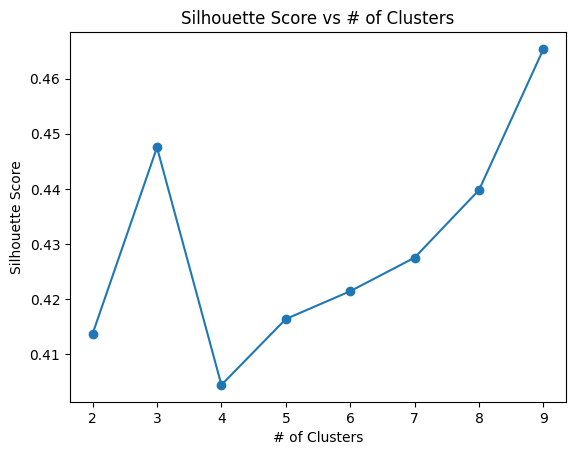

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cluster_range = range(2, 10)

scores = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X)
    scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(cluster_range, scores, marker='o')
plt.title("Silhouette Score vs # of Clusters")
plt.xlabel("# of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

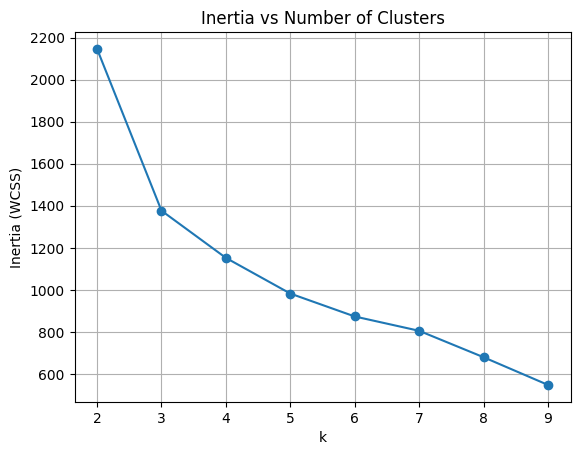

In [6]:
inertias = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.title("Inertia vs Number of Clusters")
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.grid(True)
plt.show()


In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X)

df['cluster'] = labels
print(df['cluster'].value_counts())


cluster
0    153
1    108
2     63
Name: count, dtype: int64


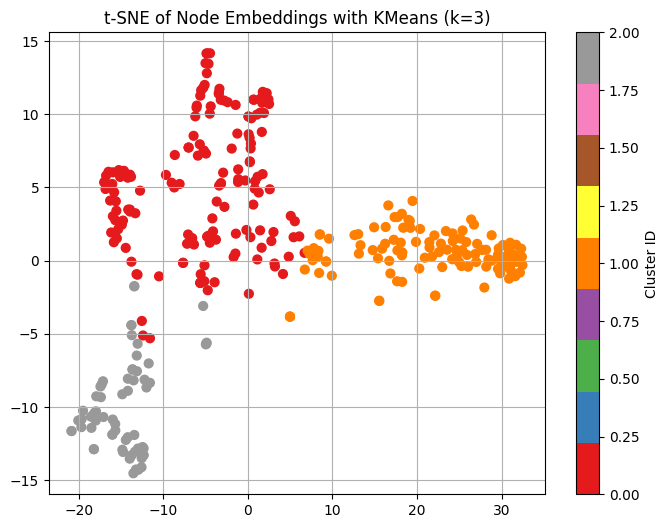

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_2d = TSNE(n_components=2, random_state=0).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='Set1', s=40)
plt.title("t-SNE of Node Embeddings with KMeans (k=3)")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()


In [13]:
node_df = pd.read_csv(PATH + 'node_features.csv')
merged_df = node_df.merge(df, on="user_id", how="inner")
merged_df = merged_df.drop(columns=embedding_cols)
merged_df.head()

,user_id,user_rt,num_post,user_time_rt,num_post_unverified,num_post_non-rumor,num_post_true,num_post_false,num_rt_unverified,num_rt_non-rumor,num_rt_true,num_rt_false,score,rt_total,cluster
0,104561999,2,0,4.4850,0,0,0,0,0,2,0,0,1.377822,0,0
1,106272436,2,0,5.0450,0,0,0,0,0,0,0,2,-0.757946,0,0
2,107663008,10,0,1945.9070,0,0,0,0,5,5,0,0,0.806700,0,2
3,1077446982,0,1,0.0000,0,0,0,1,0,0,0,0,-1.000000,252,1
4,110496588,4,0,31.6875,0,0,0,0,4,0,0,0,0.000000,0,2


In [ ]:
merged_df.groupby("cluster")["score"].mean().sort_values(ascending=False)

cluster
1    1.295104
0    0.749434
2    0.466358
Name: score, dtype: float64